In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import time
import numpy as np
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt
from resotrmer import Restormer_Denoise
from models_DnCNN import DnCNN_Denoiser
from denoise_classical import GaussianBlur, MedianBlur
import shutil
from copy import deepcopy
import pickle
import seaborn as sns
import pandas as pd
import traceback
import pickle

#Turn all the randomisation off to ensure the results of every execution is the same 
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [2]:
IMG_SIZE = 224
FOLDER_PATH = "Images/100"

restomer = Restormer_Denoise("blind")
dncnn = DnCNN_Denoiser()

denoise_methods = {
    "None": lambda x:x,
    "Restormer": restomer.denoise_image,
    "Gaussian_Blur": GaussianBlur,
    "Median_Blur": MedianBlur,
    "DnCNN": dncnn.denoise_image
}

classification_models = ["CNN", "KNN", "SVM", "Random Forest"]

models_denoising_accuracies = {model: {denoise_method: [] for denoise_method in denoise_methods.keys()}  # -1 represent not yet calculated
                               for model in classification_models}
models_denoising_f1_scores = {model: {denoise_method: [] for denoise_method in denoise_methods.keys()}  # -1 represent not yet calculated
                               for model in classification_models}
models_denoising_classification_times = {model: {denoise_method: [] for denoise_method in denoise_methods.keys()}  # -1 represent not yet calculated
                               for model in classification_models}

def build_transform(denoise_method: str) -> transforms.Compose:
    denoise_fn = denoise_methods.get(denoise_method, lambda x:x)

    return transforms.Compose([
        transforms.Lambda(denoise_fn),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

/home/brian/brian_workspace/DATA3888/venv/lib/python3.13/site-packages/torch/serialization.py:1634: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/brian/brian_workspace/DATA3888/venv/lib/python3.13/site-packages/torch/serialization.py:1634: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/brian/brian_workspace/DATA3888/venv/lib/python3.13/site-packages/torch/serialization.py:1634: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has ch

In [3]:
class ImageDataSet(Dataset):
    def __init__(self, image_names, transform):
        self.file_names = []
        self.labels = []
        for numeric_label, names in enumerate(image_names):
            self.labels.extend([numeric_label]*len(names))
            self.file_names.extend(names)

        self.transform = transform

    def __getitem__(self, index):
        img_name = self.file_names[index]
        img = Image.open(img_name).convert('RGB')
        img = self.transform(img)
        label = self.labels[index]
        return img, label
    
    def __len__(self):
        return len(self.file_names)

# labels = ["B_Cells", "CD4+_T_Cells", "DCIS_1", "DCIS_2", "Invasive_Tumor", "Prolif_Invasive_Tumor"]
labels = ["Immune_Cells", "Non_Invasive_Tumor", "Invasive_Tumor_Set"]
le = LabelEncoder()
numeric_labels = le.fit_transform(labels)
image_names = []
for _ in numeric_labels:
    image_names.append([])

for (dir_path, dir_names, file_names) in os.walk(FOLDER_PATH):
    parent_folder = os.path.basename(dir_path)
    if parent_folder in labels: # Read the subset of dataset to reduce training time 
        for file in file_names:
            image = cv2.imread(os.path.join(dir_path, file))
            if image.shape[0] < 100 and image.shape[1] < 100: #skip the small image, it doesn't give much info
                continue
            numeric_label = le.transform([parent_folder])[0]
            image_names[numeric_label].append(os.path.join(dir_path, file))

denoising_datasets = {key : ImageDataSet(image_names, build_transform(key)) for key in denoise_methods.keys()}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #check if the computer has GPU

def model_loader(path_name: str):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, len(labels))
    model.load_state_dict(torch.load(path_name))
    model = model.to(device)
    return model

denoising_cnn_models = {key : model_loader(f"denoised_models/CNN_{key}.pth") for key in denoise_methods.keys()}

/home/brian/brian_workspace/DATA3888/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brian/brian_workspace/DATA3888/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
# hyper-parameters setting
num_epochs = 100
patience = 10 #for early stopping
batch_size = 128
learning_rate = 0.001

In [6]:
def split_dataset(dataset: ImageDataSet):
    _, subset = train_test_split(list(range(len(dataset))), test_size=0.5, random_state=0)
    # train_idx, temp_idx = train_test_split(list(range(len(dataset))), test_size=0.3, random_state=0)
    train_idx, temp_idx = train_test_split(subset, test_size=0.3, random_state=0)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=0)

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    test_subset = Subset(dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

def get_test_loader(dataset: ImageDataSet):
    subset, _ = train_test_split(list(range(len(dataset))), test_size=0.5, random_state=0)
    test_loader = DataLoader(Subset(dataset, subset), batch_size=batch_size, shuffle=False, pin_memory=True)
    return test_loader

In [7]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# CNN
for denoise, dataset in denoising_datasets.items():
    print(f"Training CNN with {denoise} denoising")

    test_loader = get_test_loader(dataset)
    all_indices = list(range(len(test_loader.dataset)))
    all_labels = [test_loader.dataset[i][1] for i in all_indices]

    model = denoising_cnn_models[denoise]
    model.eval()

    for _, val_idx in kf.split(all_indices, all_labels):
        val_subset = Subset(test_loader.dataset, val_idx)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, pin_memory=True)
        y_true = []
        y_pred = []

        start = time.time()
        with torch.no_grad():
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                outputs = model(image)
                _, predicted = torch.max(outputs, 1)
                
                y_true.extend(label.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        end = time.time()

        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        classification_time = end - start
        
        models_denoising_accuracies["CNN"][denoise].append(accuracy)
        models_denoising_f1_scores["CNN"][denoise].append(f1)
        models_denoising_classification_times["CNN"][denoise].append(classification_time)
        print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Classification Time: {classification_time:.4f} seconds")

    

Training CNN with None denoising
Accuracy: 0.7601, F1 Score: 0.7517, Classification Time: 10.3592 seconds
Accuracy: 0.7593, F1 Score: 0.7517, Classification Time: 10.1937 seconds
Accuracy: 0.7614, F1 Score: 0.7534, Classification Time: 10.1569 seconds
Accuracy: 0.7567, F1 Score: 0.7500, Classification Time: 10.1750 seconds
Accuracy: 0.7535, F1 Score: 0.7457, Classification Time: 10.1356 seconds
Accuracy: 0.7604, F1 Score: 0.7523, Classification Time: 10.1794 seconds
Accuracy: 0.7562, F1 Score: 0.7484, Classification Time: 10.1842 seconds
Accuracy: 0.7595, F1 Score: 0.7530, Classification Time: 10.1692 seconds
Accuracy: 0.7432, F1 Score: 0.7352, Classification Time: 10.1172 seconds
Accuracy: 0.7514, F1 Score: 0.7433, Classification Time: 10.1476 seconds
Training CNN with Restormer denoising
Accuracy: 0.9047, F1 Score: 0.9054, Classification Time: 322.4298 seconds
Accuracy: 0.8976, F1 Score: 0.8986, Classification Time: 322.4762 seconds
Accuracy: 0.9000, F1 Score: 0.9009, Classification 

In [30]:
def feature_extractor(model, test_loader):
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1]) # remove the last layer
    feature_extractor.eval()
    feature_extractor.to(device)

    test_features = []
    test_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            output = feature_extractor(images).squeeze()
            test_features.append(output.cpu().numpy())
            test_labels.append(labels.cpu().numpy())

    X_test = np.vstack(test_features)
    y_test = np.hstack(test_labels)

    return X_test, y_test

In [31]:
for denoise, dataset in denoising_datasets.items():
    print(f"Testing {denoise} denoising")
    test_loader = get_test_loader(dataset)
    all_indices = list(range(len(test_loader.dataset)))
    all_labels = [test_loader.dataset[i][1] for i in all_indices]

    model = denoising_cnn_models[denoise]
    model.eval()

    for _, val_idx in kf.split(all_indices, all_labels):
        val_subset = Subset(test_loader.dataset, val_idx)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, pin_memory=True)
        feature_extraction_start = time.time()
        X_test, y_test = feature_extractor(model, val_loader)
        feature_extraction_end = time.time()
        feature_extraction_time = feature_extraction_end - feature_extraction_start

        with open(f"denoised_models/SVM_{denoise}.pkl", "rb") as f:
            svm = pickle.load(f)
        with open(f"denoised_models/RF_{denoise}.pkl", "rb") as f:
            rf = pickle.load(f)

        if denoise == "None":
            with open(f"denoised_models/9NN_{denoise}.pkl", "rb") as f:
                knn = pickle.load(f)
        elif denoise == "Restormer":
            with open(f"denoised_models/27NN_{denoise}.pkl", "rb") as f:
                knn = pickle.load(f)
        elif denoise == "Gaussian_Blur":
            with open(f"denoised_models/11NN_{denoise}.pkl", "rb") as f:
                knn = pickle.load(f)
        elif denoise == "Median_Blur":
            with open(f"denoised_models/27NN_{denoise}.pkl", "rb") as f:
                knn = pickle.load(f)
        elif denoise == "DnCNN":
            with open(f"denoised_models/21NN_{denoise}.pkl", "rb") as f:
                knn = pickle.load(f)

        start = time.time()
        y_pred = svm.predict(X_test)
        end = time.time()

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        classification_time = end - start + feature_extraction_time

        models_denoising_accuracies["SVM"][denoise].append(accuracy)
        models_denoising_f1_scores["SVM"][denoise].append(f1)
        models_denoising_classification_times["SVM"][denoise].append(classification_time)
        print(f"SVM - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Classification Time: {classification_time:.4f} seconds")

        start = time.time()
        y_pred = rf.predict(X_test)
        end = time.time()

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        classification_time = end - start + feature_extraction_time

        models_denoising_accuracies["Random Forest"][denoise].append(accuracy)
        models_denoising_f1_scores["Random Forest"][denoise].append(f1)
        models_denoising_classification_times["Random Forest"][denoise].append(classification_time)
        print(f"Random Forest - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Classification Time: {classification_time:.4f} seconds")

        start = time.time()
        y_pred = knn.predict(X_test)
        end = time.time()
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        classification_time = end - start + feature_extraction_time

        models_denoising_accuracies["KNN"][denoise].append(accuracy)
        models_denoising_f1_scores["KNN"][denoise].append(f1)
        models_denoising_classification_times["KNN"][denoise].append(classification_time)
        print(f"KNN - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Classification Time: {classification_time:.4f} seconds")

Testing None denoising
SVM - Accuracy: 0.6785, F1 Score: 0.6167, Classification Time: 23.8738 seconds
Random Forest - Accuracy: 0.6864, F1 Score: 0.6321, Classification Time: 10.0998 seconds
KNN - Accuracy: 0.6491, F1 Score: 0.5725, Classification Time: 10.3633 seconds
SVM - Accuracy: 0.6635, F1 Score: 0.6013, Classification Time: 23.7815 seconds
Random Forest - Accuracy: 0.6798, F1 Score: 0.6320, Classification Time: 10.0364 seconds
KNN - Accuracy: 0.6459, F1 Score: 0.5693, Classification Time: 10.2994 seconds
SVM - Accuracy: 0.6785, F1 Score: 0.6165, Classification Time: 23.8044 seconds
Random Forest - Accuracy: 0.6908, F1 Score: 0.6420, Classification Time: 10.0701 seconds
KNN - Accuracy: 0.6535, F1 Score: 0.5768, Classification Time: 10.3334 seconds
SVM - Accuracy: 0.6698, F1 Score: 0.6121, Classification Time: 23.8330 seconds
Random Forest - Accuracy: 0.6827, F1 Score: 0.6340, Classification Time: 10.0962 seconds
KNN - Accuracy: 0.6457, F1 Score: 0.5714, Classification Time: 10.35

In [40]:
with open("denoised_cv_results/models_denoising_accuracies.pkl", "wb") as f:
    pickle.dump(models_denoising_accuracies, f)
with open("denoised_cv_results/models_denoising_f1_scores.pkl", "wb") as f:
    pickle.dump(models_denoising_f1_scores, f)
with open("denoised_cv_results/models_denoising_classification_times.pkl", "wb") as f:
    pickle.dump(models_denoising_classification_times, f)

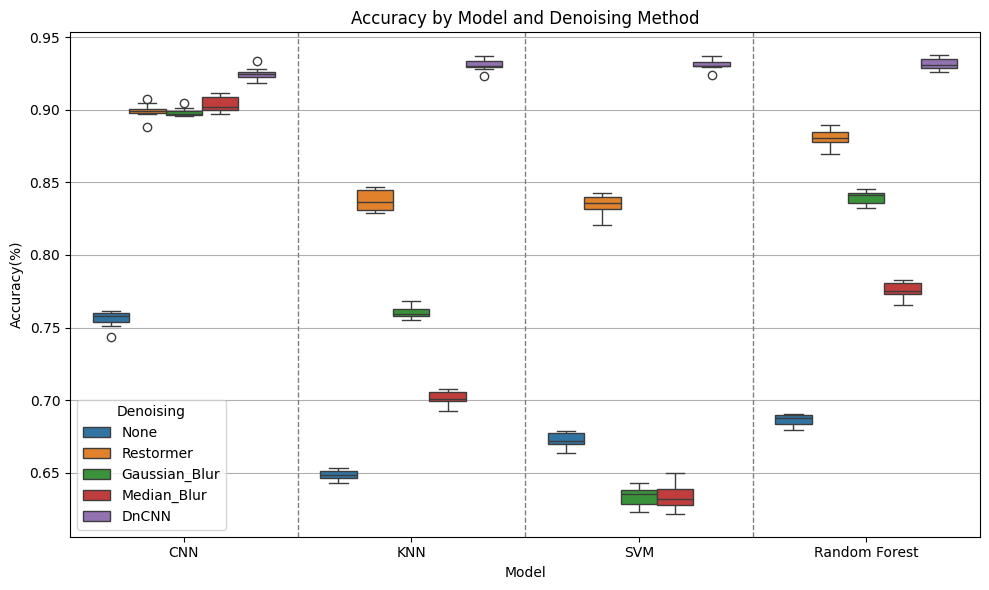

In [41]:
df_nested = pd.DataFrame(models_denoising_accuracies).T  # Models become rows
df_nested.reset_index(inplace=True)
df_nested = df_nested.melt(id_vars='index', var_name='Denoising', value_name='Accuracy')
df_nested.columns = ['Model', 'Denoising', 'Accuracy(%)']

df_long = df_nested.explode('Accuracy(%)', ignore_index=True)

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x='Model', y='Accuracy(%)', hue='Denoising')

# Add vertical lines between model groups
xticks = ax.get_xticks()
for i in range(1, len(xticks)):
    plt.axvline(x=(xticks[i-1] + xticks[i]) / 2, color='gray', linestyle='--', linewidth=1)

plt.title("Accuracy by Model and Denoising Method")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

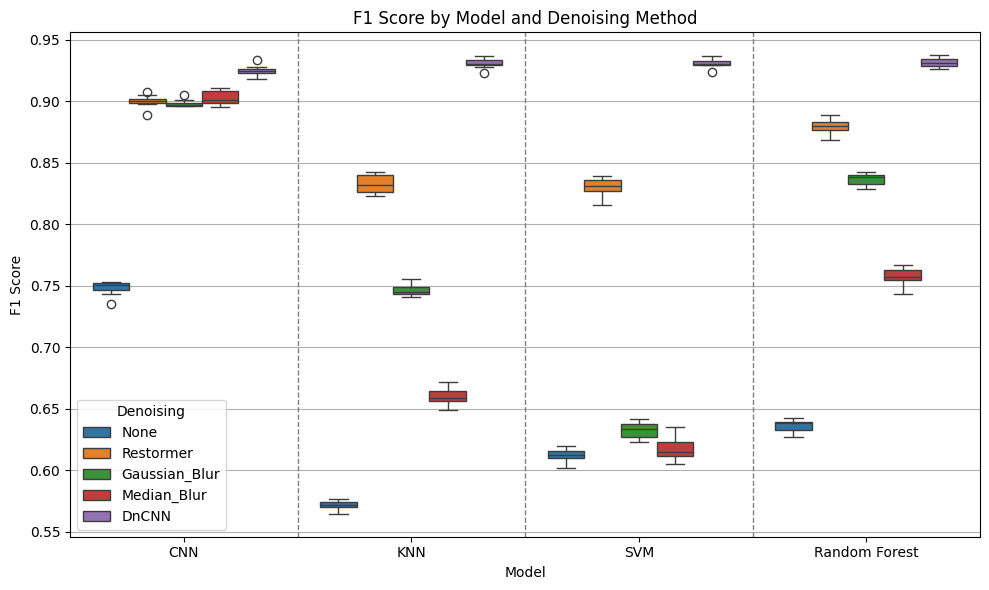

In [39]:
df_nested = pd.DataFrame(models_denoising_f1_scores).T  # Models become rows
df_nested.reset_index(inplace=True)
df_nested = df_nested.melt(id_vars='index', var_name='Denoising', value_name='F1_Score')
df_nested.columns = ['Model', 'Denoising', 'F1 Score']

df_long = df_nested.explode('F1 Score', ignore_index=True)

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x='Model', y='F1 Score', hue='Denoising')

# Add vertical lines between model groups
xticks = ax.get_xticks()
for i in range(1, len(xticks)):
    plt.axvline(x=(xticks[i-1] + xticks[i]) / 2, color='gray', linestyle='--', linewidth=1)

plt.title("F1 Score by Model and Denoising Method")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

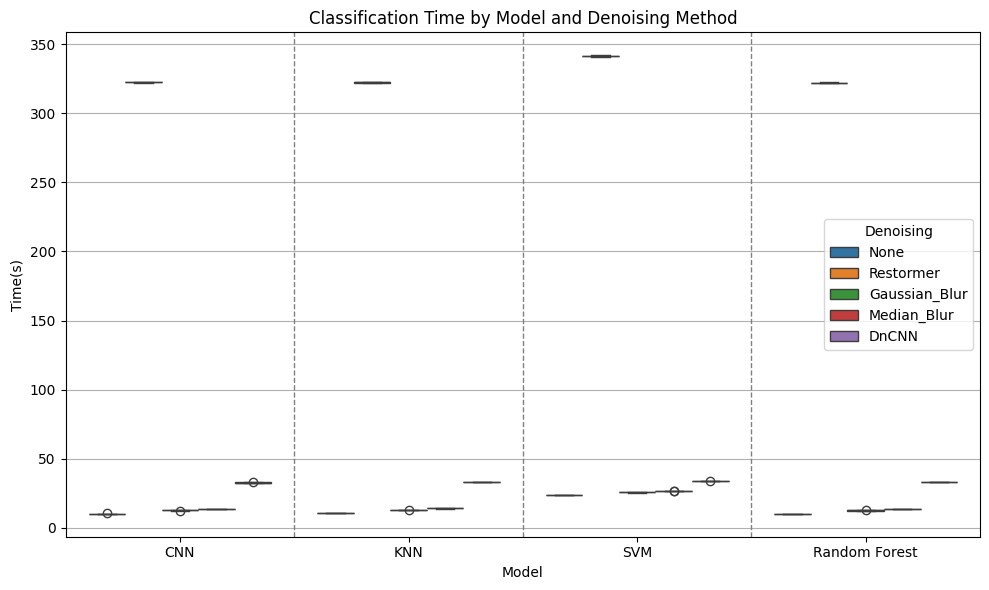

In [38]:
df_nested = pd.DataFrame(models_denoising_classification_times).T  # Models become rows
df_nested.reset_index(inplace=True)
df_nested = df_nested.melt(id_vars='index', var_name='Denoising', value_name='Time(s)')
df_nested.columns = ['Model', 'Denoising', 'Time(s)']

df_long = df_nested.explode('Time(s)', ignore_index=True)

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x='Model', y='Time(s)', hue='Denoising')

# Add vertical lines between model groups
xticks = ax.get_xticks()
for i in range(1, len(xticks)):
    plt.axvline(x=(xticks[i-1] + xticks[i]) / 2, color='gray', linestyle='--', linewidth=1)

plt.title("Classification Time by Model and Denoising Method")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()